# Deep Learning - Using Neural Networks to classify CIFAR10 Images

Can you classify an image from the CIFAR10 image library using a Neural Network?

## Table of Contents

* [1. Introduction](#introduction)
* [2. Importing libraries](#libraries)
* [3. Importing and preparing the data](#data)
* [4. Neural Network models](#nn_models)
    * [4.1. Simplest model](#simplest_model)
        * [4.1.1. Model definition](#model_definition)
        * [4.1.2. Optimizer, error function](#optimizer_error)
        * [4.1.3. Model training](#training)
        * [4.1.4. Model evaluation](#evaluation)
    * [4.2. Adding more Dense layers](#more_dense_layers)
    * [4.3. Do batch sizes matter?](#batch_sizes)
    * [4.4. Exploring the effects of adding Dropout](#dropout)
    * [4.5. Simple Convolutional Neural Network](#simple_cnn)
    * [4.6. Extending the Convolutional Neural Network](#cnn_extended)
    * [4.7. Fine tuning the convolutional layer a little bit more](#cnn_tunning)
    * [4.8. Adam Optimizer parameters fine tuning](#adam_tuning)
    * [4.9. Using Data Augmentation](#data_augmentation)
        * [4.9.1. Creating an image train generator](#train_generator)
        * [4.9.2. Training the model with the image train generator](#train_generator_training_model)
    * [4.10. Concatenating convolutional layers before Pooling (with Data Augmentation and BatchNormalization)](#convo_concat_batchNorm_DA)
    * [4.11. Is Data Augmentation a key factor for accuracy?](#is_DA_needed)
    * [4.12. Using an already trained 3rd party model (Transfer Learning)](#transfer_learning)
* [5. Models comparison](#comparison)

## 1. Introduction <a class="anchor" id="introduction"></a>

The main goal of this project is to test several Neural Networks configurations in order to do the proper classification of the CIFAR10 image dataset.

## 2. Importing libraries <a class="anchor" id="libraries"></a>

In [6]:
# data manipulation libraries
import numpy as np
import pandas as pd
import tensorflow

# neural network libraries
from tensorflow import keras as ks
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import Model

# plotting libraries
from matplotlib import pyplot as plt

# time libraries
import time
import datetime

In [7]:
# constants
EPOCHS = 100
INPUT_SHAPE = (32, 32, 3)
ACC_TARGET = 80 # accuracy target we want to at least achieve with our models

## 3. Importing and preparing the data <a class="anchor" id="data"></a>

CIFAR10 is an existing dataset already available in the Keras library. These are already ready in train and test datasets (we'll need to create the validation dataset later).

**Important detail:**
> The neural network requires the inputs to be real numbers, and we will do it by forcing the division of the values ​​within the 28x28 matrices (which have values​​ from 0 to 255) by 255.0 (a real)

In [8]:
cifar10 = ks.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

170498071/170498071 [==============================] - 80s 0us/step


Let's explore the data to see what we have.

In [9]:
print('Train: X = %s, y = %s' % (x_train.shape, y_train.shape))
print('Test: X = %s, y = %s' % (x_test.shape, y_test.shape))

Train: X = (50000, 32, 32, 3), y = (50000, 1)
Test: X = (10000, 32, 32, 3), y = (10000, 1)


For training, we have 50000 images of 32x32 pixels, split in the color channels (R, G, B). For testing, we only have 1000 images, but, obviously, of the same format as the training dataset.

Let's see what are the different categories we have in the dataset.

In [10]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

As expected, there are 10 categories that are already encoded into numbers. However, we will generate a label list for future plotting purposes.

In [11]:
cifar10_labels = [
'airplane', # id 0
'automobile', # id 1
'bird', # id 2
'cat', # id 3
'deer', # id 4
'dog', # id 5
'frog', # id 6
'horse', # id 7
'ship', # id 8
'truck', # id 9
]

print('Number of labels: %s' % len(cifar10_labels))

Number of labels: 10


Let's show a sample of the images from the CIFAR10 dataset, to see if it looks anything like what we expect.

First, we see what types of data we have, then we map those arrays in a grayscale using the **. Get_cmap ()** method of Plotly with the first nine numbers of the dataset.

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


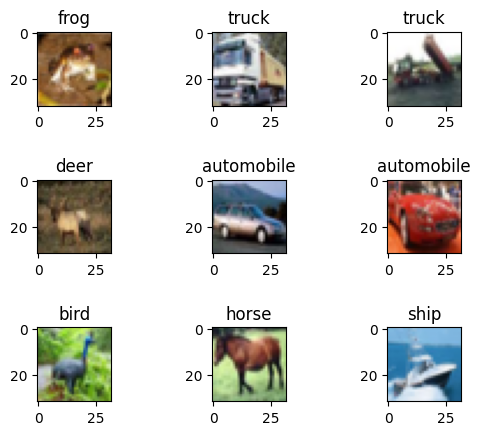

In [12]:
# Let's show a sample of the images of CIFAR10

print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

for i in range(9):

    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i], cmap = plt.get_cmap('gray'))
    plt.title(cifar10_labels[y_train[i,0]])

plt.subplots_adjust(hspace = 1)
plt.show()

Let's start preparing the datasets for the models we will train. 

We are we going to validate while we train (very practical). We'll be removing the last 10000 entries in `x_train` for our validation dataset. 

In [13]:
# generating the validation dataset
x_val = x_train[-10000:]
y_val = y_train[-10000:]

# modifying the training dataset to exclude the validation dataset
x_train = x_train[:-10000]
y_train = y_train[:-10000]

When we add convolution layers, we need to "pre-treat the data", because **the convolution expects an array of 4 fields** (more like coloured "images"), in the case of MNIST. However, CIFAR10 already has the right shape, so we don't have to do anything, but as we always say: you should better check its size.

Therefore, when exiting the Convolution, you always have to do a Flatten, because FullDense layers expect arrays, not matrices !!

Let's validate the format.

In [14]:
# We validate the result
print('Train: X = %s, y = %s' % (x_train.shape, y_train.shape))
print('Test: X = %s, y = %s' % (x_test.shape, y_test.shape))
print('Validation: X = %s, y = %s' % (x_val.shape, y_val.shape))

Train: X = (40000, 32, 32, 3), y = (40000, 1)
Test: X = (10000, 32, 32, 3), y = (10000, 1)
Validation: X = (10000, 32, 32, 3), y = (10000, 1)


## 4. Neural Network Models <a class="anchor" id="nn_models"></a>

In the following sections, we are going to define and train up to 10 different Neural Network models to see which arquitecture is providing the best accuracy.

Nonetheless, before starting with the models let's set a couple of previous tunings that will help us later with the training

In [15]:
# defining callbacks for EarlyStopping
callback_loss = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)
callback_accuracy = EarlyStopping(monitor = 'val_accuracy', patience = 5, restore_best_weights = True)

# list to keep the model results for final comparison
model_evaluations = []

### 4.1. Simplest model <a class="anchor" id="simplest_model"></a>

Let's start with the simplest model possible with a single Dense Layer

#### 4.1.1. Model definition <a class="anchor" id="model_definition"></a>


In [16]:
model = ks.Sequential()

# Neural Network Layers
model.add(ks.layers.Flatten(input_shape = INPUT_SHAPE))
model.add(ks.layers.Dense(128, activation='relu'))
model.add(ks.layers.Dense(10, activation='softmax'))

# review model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 128)               393344    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 394,634
Trainable params: 394,634
Non-trainable params: 0
_________________________________________________________________


#### 4.1.2. Optimizer, error function <a class="anchor" id="optimizer_error"></a>


In [17]:
# compiling model
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### 4.1.3. Training <a class="anchor" id="training"></a>

In order to train the model we have setup a global constant of 100 EPOCHS, which we expect to never reach, as we have implemented a callback to stop training once the accuracy or the cross entropy loss doesn't improve that much. Additionally, we are going to keep the best weights to get the most optimal results for the model.

In [18]:
# calculating computational time
t = time.perf_counter()

# training model
history = model.fit(
                    x_train, 
                    y_train, 
                    epochs = EPOCHS, 
                    use_multiprocessing = False, 
                    batch_size = 128, 
                    validation_data = (x_val, y_val),
                    callbacks = [callback_accuracy, callback_loss]
          )

# show total elapsed time
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))
print('\nTraining time:', elapsed_time)

Epoch 1/100
313/313 [==============================] - 12s 16ms/step - loss: 1.9581 - accuracy: 0.3058 - val_loss: 1.8224 - val_accuracy: 0.3674
Epoch 2/100
313/313 [==============================] - 5s 15ms/step - loss: 1.7867 - accuracy: 0.3729 - val_loss: 1.7878 - val_accuracy: 0.3663
Epoch 3/100
313/313 [==============================] - 5s 16ms/step - loss: 1.7372 - accuracy: 0.3886 - val_loss: 1.7533 - val_accuracy: 0.3810
Epoch 4/100
313/313 [==============================] - 4s 13ms/step - loss: 1.6927 - accuracy: 0.4065 - val_loss: 1.7112 - val_accuracy: 0.4006
Epoch 5/100
313/313 [==============================] - 6s 18ms/step - loss: 1.6654 - accuracy: 0.4144 - val_loss: 1.6981 - val_accuracy: 0.4092
Epoch 6/100
313/313 [==============================] - 5s 17ms/step - loss: 1.6329 - accuracy: 0.4266 - val_loss: 1.6910 - val_accuracy: 0.4060
Epoch 7/100
313/313 [==============================] - 4s 13ms/step - loss: 1.6084 - accuracy: 0.4338 - val_loss: 1.6542 - val_accuracy

#### 4.1.4. Evaluation <a class="anchor" id="evaluation"></a>

Let's obtain a graph of how the entropy and the accuracy evolve in each epoch in the training data and in the validation

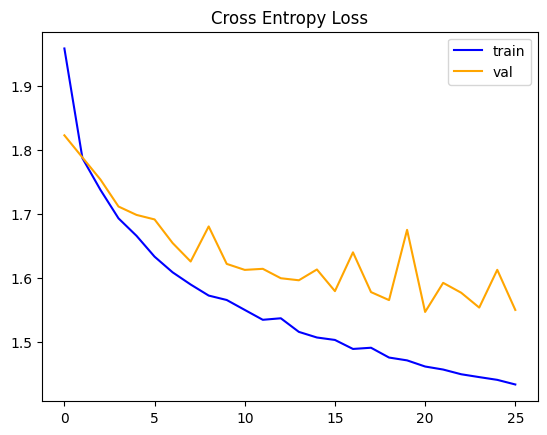

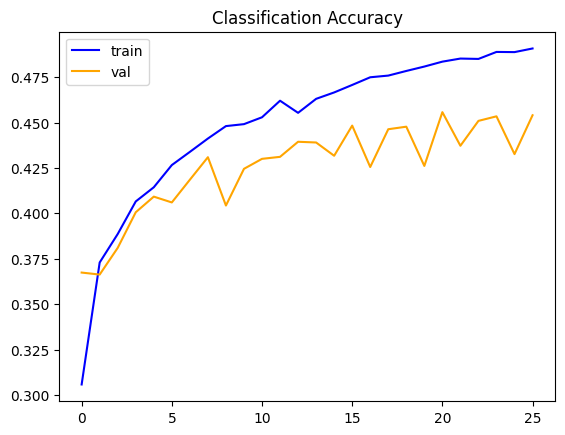

In [19]:
# cross entropy loss plot
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='val')
plt.legend()
plt.show()

# accuracy plot
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='val')
plt.legend()
plt.show()

The callbacks have stopped before EPOCH = 100 as we reached the top accuracy a lot before, and from that training session we got the best parameters parameters. However, we have seen that the validation accuracy looks really bad, so our hopes are not that high fo the test accuracy, but let's check it out.

In [20]:
_, acc = model.evaluate(x_test, y_test, verbose=0)
print(f'Test Accuracy for the model -> {round((acc * 100.0), 4)} %')

Test Accuracy for the model -> 46.82 %


As expected, the model is really bad. With this accuracy we can say that this is a really bad model that requires an improvement. But, at least we know the bottom line with a very simple network.

Let's see what kind of predictions we're getting on the test set (let's paint the images and their classifications).

In [21]:
predictions = model.predict(x_test)

313/313 [==============================] - 1s 4ms/step


In [22]:
# plotting helper functions
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label[0]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label[0]].set_color('blue')

def plot_cifar_results(predictions, x_test, y_test, num_rows = 5, num_cols = 4):
    i = 0
    for l in cifar10_labels:
        print(i, l)
        i += 1

    num_images = num_rows * num_cols
    start = np.random.randint(1000 - num_images)
    plt.figure(figsize = (2 * 2 * num_cols, 2 * num_rows))
    for i in range(num_images):
        plt.subplot(num_rows, 2 * num_cols, 2 * i +1)
        plot_image(i + start, predictions[i + start], y_test, x_test)
        plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
        plot_value_array(i + start, predictions[i + start], y_test)
    plt.tight_layout()
    plt.show()

We draw the first images, with the predictions and their real values ​​(a total of 20 images, so as not to abuse your laptops)

We color the correct predictions in blue and the failures in red. Although I have printed the labels first so that we have a reference to the graphic.

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


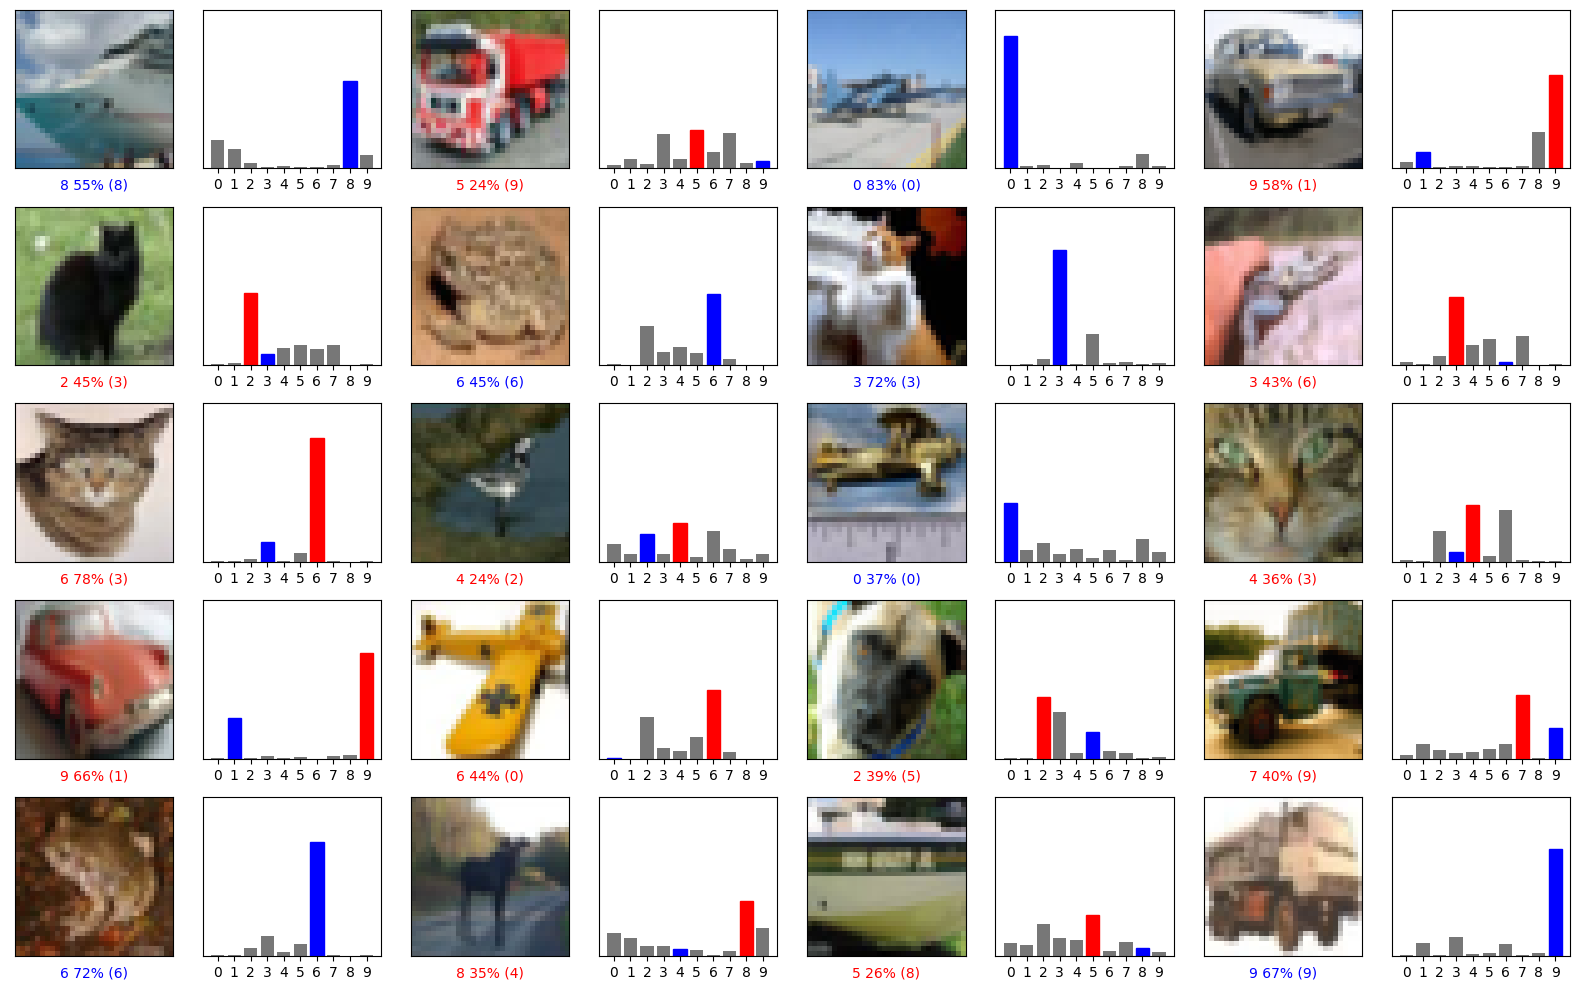

In [23]:
plot_cifar_results(predictions, x_test, y_test)

Let's see if we can build up the previous model to improve the accuracy, but before that, let's store the accuracy of this model so we can compare it at the end with all the other models.

In [24]:
# keeping accuracies for a final analysis
model_evaluations.append(
    {
        'model_name': "Single Dense Layer",
        'training_time': elapsed_time,
        'accuracy': acc
    }
)

### 4.2. Adding more Dense layers <a class="anchor" id="more_dense_layers"></a>

Before defining the model we will create some additional functions to avoid code repetition and possible errors. The idea is to prepare as much of a pipeline as possible so we can analyse results more easily.

In [25]:
def model_evaluation(model, x_test, y_test, history, plot_graphs = True):
    if plot_graphs:
        # cross entropy loss plot
        plt.title('Cross Entropy Loss')
        plt.plot(history.history['loss'], color='blue', label='train')
        plt.plot(history.history['val_loss'], color='orange', label='val')
        plt.legend()
        plt.show()

        # accuracy plot
        plt.title('Classification Accuracy')
        plt.plot(history.history['accuracy'], color='blue', label='train')
        plt.plot(history.history['val_accuracy'], color='orange', label='val')
        plt.legend()
        plt.show()

    # accuracy evaluation
    _, acc = model.evaluate(x_test, y_test, verbose=0)
    print(f'Test Accuracy for the model -> {round((acc * 100.0), 4)} %\n')

    predictions = model.predict(x_test)
   
    return acc

def storing_evaluation_results(model_list, model_name, accuracy, training_time):
    model_list.append(
        {
          'model_name': model_name,
          'training_time': training_time,
          'accuracy': accuracy
        }
    )

From the previous model, we have seen that with just one fully Dense layer is not enough for the model to work properly, in this case, we will be adding more Dense Layers to see if the result improves.

DEFINITION
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1573376   
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 10)                650       
                                                                 
Total params: 1,746,506
Trainable params: 1

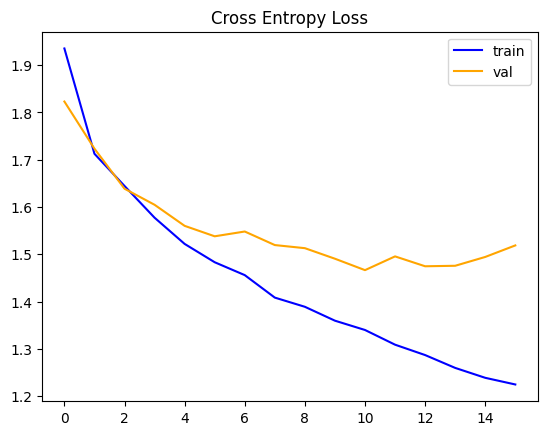

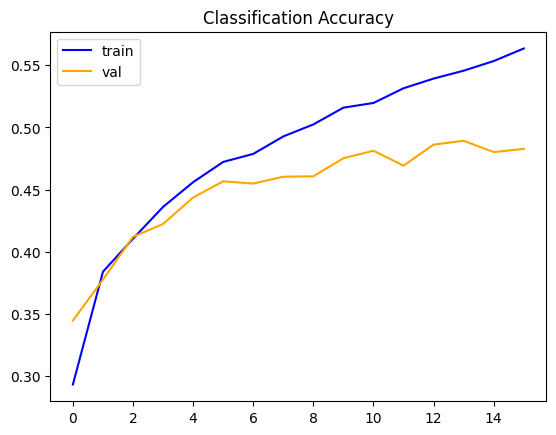

Test Accuracy for the model -> 48.92 %

313/313 [==============================] - 2s 6ms/step


In [26]:
# MODEL DEFINITION
print("DEFINITION")

model = ks.Sequential()

# Neural Network Layers
model.add(ks.layers.Flatten(input_shape = INPUT_SHAPE))
model.add(ks.layers.Dense(512, activation='relu'))
model.add(ks.layers.Dense(256, activation='relu'))
model.add(ks.layers.Dense(128, activation='relu'))
model.add(ks.layers.Dense(64, activation='relu'))
model.add(ks.layers.Dense(10, activation='softmax'))

# review model
model.summary()


# COMPILING MODEL
print("\nCompiling model...")
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# TRAINING
print("\nTRAINING")
# calculating computational time
t = time.perf_counter()
# training model
history = model.fit(
                    x_train, 
                    y_train, 
                    epochs = EPOCHS, 
                    use_multiprocessing = False, 
                    batch_size = 128, 
                    validation_data = (x_val, y_val),
                    callbacks = [callback_accuracy, callback_loss]
          )
# show total elapsed time
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))
print('\n\nTraining time:', elapsed_time)


# EVALUATION
print("\nEVALUATION")
acc = model_evaluation(model, x_test, y_test, history, True)

In [27]:
# STORING RESULTS

# keeping accuracies for a final analysis
storing_evaluation_results(model_evaluations, 'Several Dense Layers', acc, elapsed_time)

### 4.3. Do batch sizes matter? <a class="anchor" id="batch_sizes"></a>

Let's explore if the batch sizes of data can help us improve the training of our model or not. We will increase batch_size to 512, instead of 128.

DEFINITION
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 3072)              0         
                                                                 
 dense_7 (Dense)             (None, 512)               1573376   
                                                                 
 dense_8 (Dense)             (None, 256)               131328    
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 10)                650       
                                                                 
Total params: 1,746,506
Trainable params: 1

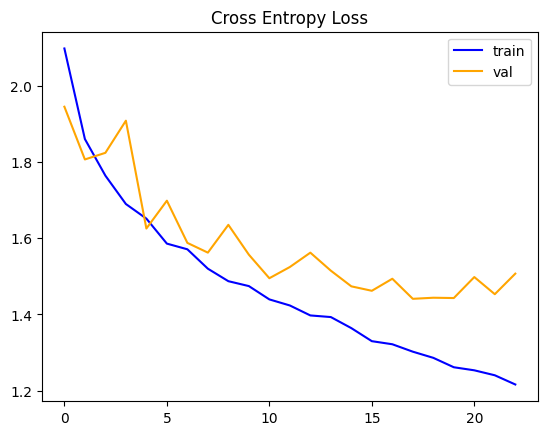

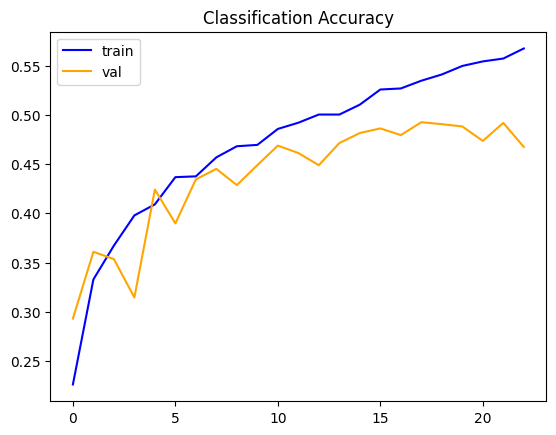

Test Accuracy for the model -> 50.3 %

313/313 [==============================] - 2s 5ms/step


In [28]:
# MODEL DEFINITION
print("DEFINITION")

model = ks.Sequential()

# Neural Network Layers
model.add(ks.layers.Flatten(input_shape = INPUT_SHAPE))
model.add(ks.layers.Dense(512, activation='relu'))
model.add(ks.layers.Dense(256, activation='relu'))
model.add(ks.layers.Dense(128, activation='relu'))
model.add(ks.layers.Dense(64, activation='relu'))
model.add(ks.layers.Dense(10, activation='softmax'))

# review model
model.summary()


# COMPILING MODEL
print("\nCompiling model...")
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# TRAINING
print("\nTRAINING")
# calculating computational time
t = time.perf_counter()
# training model
history = model.fit(
                    x_train, 
                    y_train, 
                    epochs = EPOCHS, 
                    use_multiprocessing = False, 
                    batch_size = 512, 
                    validation_data = (x_val, y_val),
                    callbacks = [callback_accuracy, callback_loss]
          )
# show total elapsed time
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))
print('\n\nTraining time:', elapsed_time)


# EVALUATION
print("\nEVALUATION")
acc = model_evaluation(model, x_test, y_test, history, True)

In [29]:
storing_evaluation_results(model_evaluations, 'Increasing Batch Size', acc, elapsed_time)

### 4.4. Exploring the effects of adding Dropout <a class="anchor" id="dropout"></a>


Dropout is referred to the effect of randomly removing nodes in a neural network and it is a technique to avoid overfitting. This makes sense to do in the Dense or fully connected layers. 

Let's see if that improves the results.

DEFINITION
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 3072)              0         
                                                                 
 dense_12 (Dense)            (None, 512)               1573376   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_14 (Dense)            (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)   

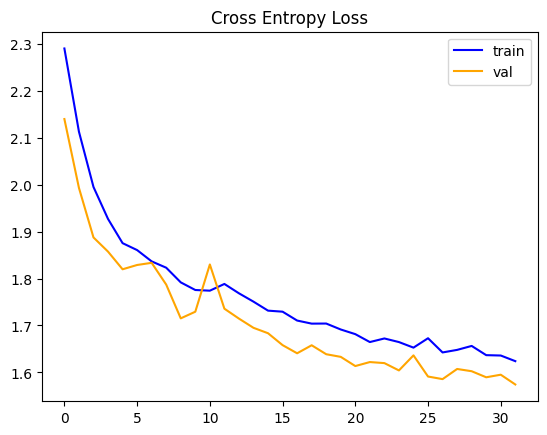

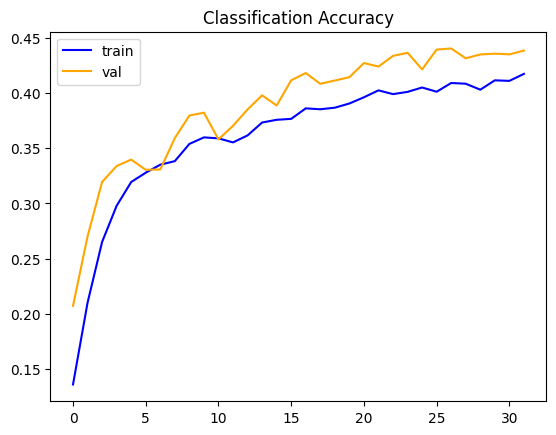

Test Accuracy for the model -> 44.8 %

313/313 [==============================] - 2s 5ms/step


In [30]:
# MODEL DEFINITION
print("DEFINITION")

model = ks.Sequential()

# Neural Network Layers
model.add(ks.layers.Flatten(input_shape = INPUT_SHAPE))
model.add(ks.layers.Dense(512, activation='relu'))
model.add(ks.layers.Dropout(0.25))
model.add(ks.layers.Dense(256, activation='relu'))
model.add(ks.layers.Dropout(0.25))
model.add(ks.layers.Dense(128, activation='relu'))
model.add(ks.layers.Dropout(0.25))
model.add(ks.layers.Dense(64, activation='relu'))
model.add(ks.layers.Dropout(0.25))
model.add(ks.layers.Dense(10, activation='softmax'))

# review model
model.summary()


# COMPILING MODEL
print("\nCompiling model...")
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# TRAINING
print("\nTRAINING")
# calculating computational time
t = time.perf_counter()
# training model
history = model.fit(
                    x_train, 
                    y_train, 
                    epochs = EPOCHS, 
                    use_multiprocessing = False, 
                    batch_size = 1024, 
                    validation_data = (x_val, y_val),
                    callbacks = [callback_accuracy, callback_loss]
          )
# show total elapsed time
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))
print('\n\nTraining time:', elapsed_time)


# EVALUATION
print("\nEVALUATION")
acc = model_evaluation(model, x_test, y_test, history, True)

In [31]:
storing_evaluation_results(model_evaluations, 'Adding Dropout Layers', acc, elapsed_time)

### 4.5. Simple Convolutional Neural Network <a class="anchor" id="simple_cnn"></a>

Up until now, we have tried to solve the classification problem by forcing the neural network to learn about values of pixels (features) in different color spaces, but what if we could provide it with "vision". If the network was able to see and understand the shapes of the image data it gets, we believe it would be more efficient.

Let's start with a simple Convolutional Network (with just 1 layer) and expand from there.

DEFINITION
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_17 (Dense)            (None, 512)               4194816   
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_18 (Dense)            (None, 256)               131328    
                                           

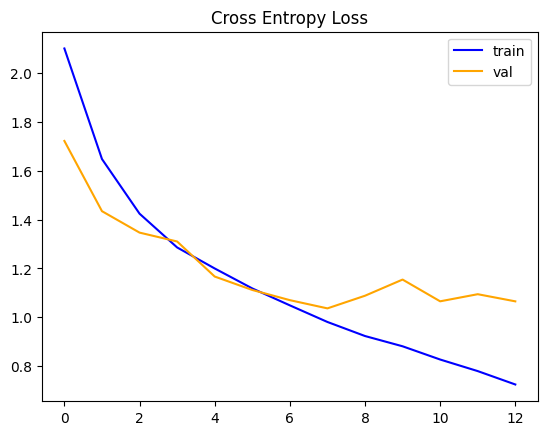

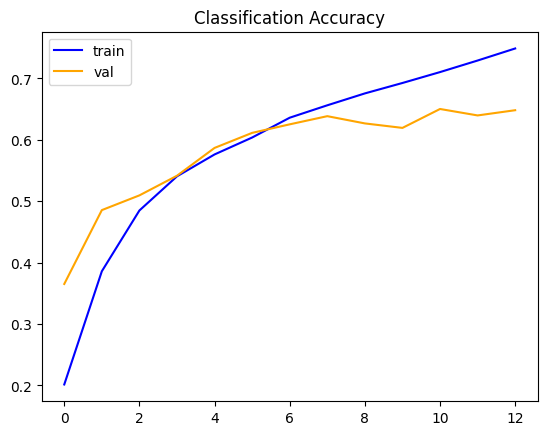

Test Accuracy for the model -> 63.73 %

313/313 [==============================] - 5s 16ms/step


In [32]:
# MODEL DEFINITION
print("DEFINITION")

model = ks.Sequential()

# Neural Network Layers
model.add(ks.layers.Conv2D(32, (3, 3), strides=1, activation='relu', padding='same', input_shape=INPUT_SHAPE))
model.add(ks.layers.MaxPooling2D((2, 2)))

model.add(ks.layers.Flatten()) 
model.add(ks.layers.Dense(512, activation='relu'))
model.add(ks.layers.Dropout(0.25))
model.add(ks.layers.Dense(256, activation='relu'))
model.add(ks.layers.Dropout(0.25))
model.add(ks.layers.Dense(128, activation='relu'))
model.add(ks.layers.Dropout(0.25))
model.add(ks.layers.Dense(64, activation='relu'))
model.add(ks.layers.Dropout(0.25))
model.add(ks.layers.Dense(10, activation='softmax'))

# review model
model.summary()


# COMPILING MODEL
print("\nCompiling model...")
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# TRAINING
print("\nTRAINING")
# calculating computational time
t = time.perf_counter()
# training model
history = model.fit(
                    x_train, 
                    y_train, 
                    epochs = EPOCHS, 
                    use_multiprocessing = False, 
                    batch_size = 512, 
                    validation_data = (x_val, y_val),
                    callbacks = [callback_accuracy, callback_loss]
          )
# show total elapsed time
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))
print('\n\nTraining time:', elapsed_time)


# EVALUATION
print("\nEVALUATION")
acc = model_evaluation(model, x_test, y_test, history, True)

With just one convolutional layer, the increase in accuracy has been impressive, but not enough.

In [33]:
storing_evaluation_results(model_evaluations, 'Simple Convolutional Neural Network', acc, elapsed_time)

### 4.6. Extending the Convolutional Neural Network <a class="anchor" id="cnn_extended"></a>

We have seen that by adding one layer of a convolutional neural network, the accuracy of the model improves a lot. Let's try adding more convolutional layers, following the examples of more complex architectures of neural networks that have several convolutional layers and then fully connected layers at the end.

DEFINITION
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        9280      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 4, 

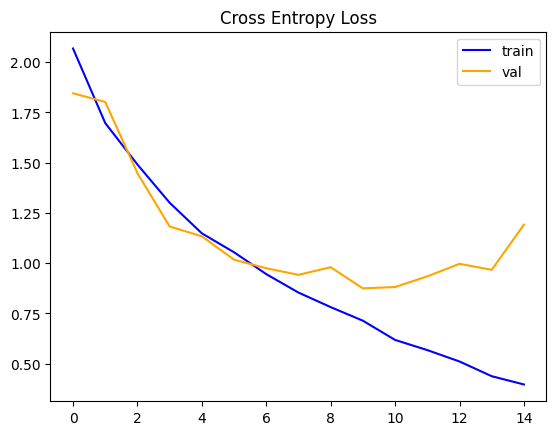

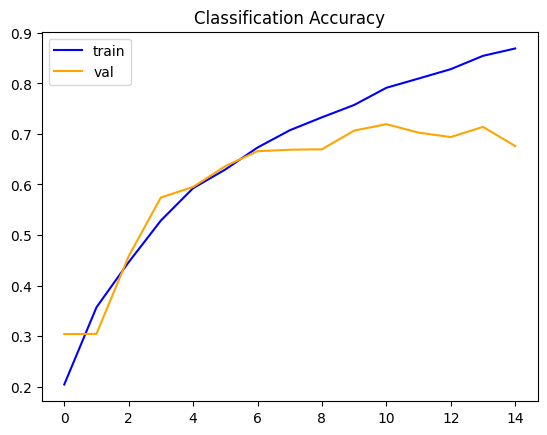

Test Accuracy for the model -> 69.47 %

313/313 [==============================] - 6s 18ms/step


In [34]:
# MODEL DEFINITION
print("DEFINITION")

model = ks.Sequential()

# Neural Network Layers
model.add(ks.layers.Conv2D(16, (3, 3), strides = 1, activation = 'relu', padding = 'same', input_shape = INPUT_SHAPE))
model.add(ks.layers.MaxPooling2D((2, 2)))

model.add(ks.layers.Conv2D(64, (3, 3), strides = 1, activation = 'relu', padding = 'same'))
model.add(ks.layers.MaxPooling2D((2, 2)))

model.add(ks.layers.Conv2D(128, (3, 3), strides = 1, activation = 'relu', padding = 'same'))
model.add(ks.layers.MaxPooling2D((2, 2)))

model.add(ks.layers.Conv2D(256, (3, 3), strides = 1, activation = 'relu', padding = 'same'))
model.add(ks.layers.MaxPooling2D((2, 2)))

model.add(ks.layers.Flatten()) 
model.add(ks.layers.Dense(512, activation='relu'))
model.add(ks.layers.Dropout(0.25))
model.add(ks.layers.Dense(256, activation='relu'))
model.add(ks.layers.Dropout(0.25))
model.add(ks.layers.Dense(128, activation='relu'))
model.add(ks.layers.Dropout(0.25))
model.add(ks.layers.Dense(64, activation='relu'))
model.add(ks.layers.Dropout(0.25))
model.add(ks.layers.Dense(10, activation='softmax'))

# review model
model.summary()


# COMPILING MODEL
print("\nCompiling model...")
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# TRAINING
print("\nTRAINING")
# calculating computational time
t = time.perf_counter()
# training model
history = model.fit(
                    x_train, 
                    y_train, 
                    epochs = EPOCHS, 
                    use_multiprocessing = False, 
                    batch_size = 512, 
                    validation_data = (x_val, y_val),
                    callbacks = [callback_accuracy, callback_loss]
          )
# show total elapsed time
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))
print('\n\nTraining time:', elapsed_time)


# EVALUATION
print("\nEVALUATION")
acc = model_evaluation(model, x_test, y_test, history, True)

Adding convolutional layers has also increased the accuracy of our previous neural network.

In [35]:
storing_evaluation_results(model_evaluations, 'Complex Convolutional Neural Network', acc, elapsed_time)

### 4.7. Fine tuning the convolutional layer a little bit more <a class="anchor" id="cnn_tuning"></a>

Another idea to increase the accuracy would be to make the convolutional layer bigger (VGG16 has 5 convolutional layers with higher amount of nodes than the previous model), and also make the classification layer (the fully connected one) a lot way bigger.

In [36]:
# MODEL DEFINITION
print("DEFINITION")

model = ks.Sequential()

# Neural Network Layers
model.add(ks.layers.Conv2D(64, (3, 3), strides = 1, activation = 'relu', padding = 'same', input_shape = INPUT_SHAPE))
model.add(ks.layers.MaxPooling2D((2, 2)))

model.add(ks.layers.Conv2D(128, (3, 3), strides = 1, activation = 'relu', padding = 'same'))
model.add(ks.layers.MaxPooling2D((2, 2)))

model.add(ks.layers.Conv2D(256, (3, 3), strides = 1, activation = 'relu', padding = 'same'))
model.add(ks.layers.MaxPooling2D((2, 2)))

model.add(ks.layers.Conv2D(512, (3, 3), strides = 1, activation = 'relu', padding = 'same'))
model.add(ks.layers.MaxPooling2D((2, 2)))

model.add(ks.layers.Conv2D(512, (3, 3), strides = 1, activation = 'relu', padding = 'same'))
model.add(ks.layers.MaxPooling2D((2, 2)))

model.add(ks.layers.Flatten()) 
model.add(ks.layers.Dense(4096, activation='relu'))
model.add(ks.layers.Dropout(0.25))
model.add(ks.layers.Dense(1024, activation='relu'))
model.add(ks.layers.Dropout(0.25))
model.add(ks.layers.Dense(10, activation='softmax'))

# review model
model.summary()


# COMPILING MODEL
print("\nCompiling model...")
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# TRAINING
print("\nTRAINING")
# calculating computational time
t = time.perf_counter()
# training model
history = model.fit(
                    x_train, 
                    y_train, 
                    epochs = EPOCHS, 
                    use_multiprocessing = False, 
                    batch_size = 512, 
                    validation_data = (x_val, y_val),
                    callbacks = [callback_accuracy, callback_loss]
          )
# show total elapsed time
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))
print('\n\nTraining time:', elapsed_time)


# EVALUATION
print("\nEVALUATION")
acc = model_evaluation(model, x_test, y_test, history, True)

DEFINITION
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 256)         295168    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 4, 4, 

In [ ]:
storing_evaluation_results(model_evaluations, 'VGG16-like CNN', acc, elapsed_time)

### 4.8. Adam Optimizer parameters fine tuning<a class="anchor" id="adam_tuning"></a>

Up until now, we have been focusing on the architecture of the convolutional neural network, but we haven't checked anything related to the optimizer function we are using, Adam. 

The idea with this model is to explore if fine tuning parameters such as the learning rate and the momentums, we manage to escape from local minimums and reach global minimums.

DEFINITION
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 8, 8, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 8, 8, 256)         295168    
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 4, 4, 

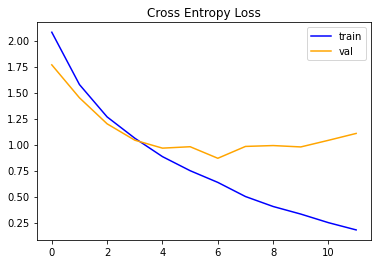

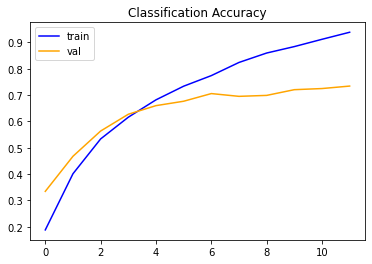

Test Accuracy for the model -> 69.94 %



In [ ]:
# MODEL DEFINITION
print("DEFINITION")

model = ks.Sequential()

# Neural Network Layers
model.add(ks.layers.Conv2D(64, (3, 3), strides = 1, activation = 'relu', padding = 'same', input_shape = INPUT_SHAPE))
model.add(ks.layers.MaxPooling2D((2, 2)))

model.add(ks.layers.Conv2D(128, (3, 3), strides = 1, activation = 'relu', padding = 'same'))
model.add(ks.layers.MaxPooling2D((2, 2)))

model.add(ks.layers.Conv2D(256, (3, 3), strides = 1, activation = 'relu', padding = 'same'))
model.add(ks.layers.MaxPooling2D((2, 2)))

model.add(ks.layers.Conv2D(512, (3, 3), strides = 1, activation = 'relu', padding = 'same'))
model.add(ks.layers.MaxPooling2D((2, 2)))

model.add(ks.layers.Conv2D(512, (3, 3), strides = 1, activation = 'relu', padding = 'same'))
model.add(ks.layers.MaxPooling2D((2, 2)))

model.add(ks.layers.Flatten()) 
model.add(ks.layers.Dense(4096, activation='relu'))
model.add(ks.layers.Dropout(0.25))
model.add(ks.layers.Dense(1024, activation='relu'))
model.add(ks.layers.Dropout(0.25))
model.add(ks.layers.Dense(10, activation='softmax'))

# review model
model.summary()


# COMPILING MODEL
print("\nCompiling model...")
optimizer = Adam(learning_rate = 0.001, decay = 0, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08)
model.compile(optimizer = optimizer,
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])


# TRAINING
print("\nTRAINING")
# calculating computational time
t = time.perf_counter()
# training model
history = model.fit(
                    x_train, 
                    y_train, 
                    epochs = EPOCHS, 
                    use_multiprocessing = False, 
                    batch_size = 512, 
                    validation_data = (x_val, y_val),
                    callbacks = [callback_accuracy, callback_loss]
          )
# show total elapsed time
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))
print('\n\nTraining time:', elapsed_time)


# EVALUATION
print("\nEVALUATION")
acc = model_evaluation(model, x_test, y_test, history, True)

In [ ]:
storing_evaluation_results(model_evaluations, 'Fine tuning Adam Optimizer parameters', acc, elapsed_time)

### 4.9. Using Data Augmentation <a class="anchor" id="data_augmentation"></a>

With a pretty complex convolutional network, we managed to increase the accuracy quite a lot. However, we are always aiming for a better model. The following approach will make use of Data Augmentation to improve the accuracy of the model by using very simple techniques of image processing to artificially expand the size of the training data by creating modified versions of the images of the original data.

#### 4.9.1. Creating an Image Train Generator <a class="anchor" id="train_generator"></a>

In [ ]:
# for Data Augmentation and this dataset, we need to encode the labels using One Hot Encoding
y_train_encoded = ks.utils.to_categorical(y_train)
y_val_encoded = ks.utils.to_categorical(y_val)
y_test_encoded = ks.utils.to_categorical(y_test)

In [ ]:
generator_batch_size = 64

# train data
train_datagen = ImageDataGenerator(
    rotation_range = 20,
    #shear_range = 0.2,
    #zoom_range = 0.2,
    horizontal_flip = True,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
)
train_generator = train_datagen.flow(
    x_train,
    y_train_encoded, 
    batch_size = generator_batch_size
)

# validation data
validation_datagen = ImageDataGenerator()
validation_generator = validation_datagen.flow(
    x_val, 
    y_val_encoded, 
    batch_size = generator_batch_size
)

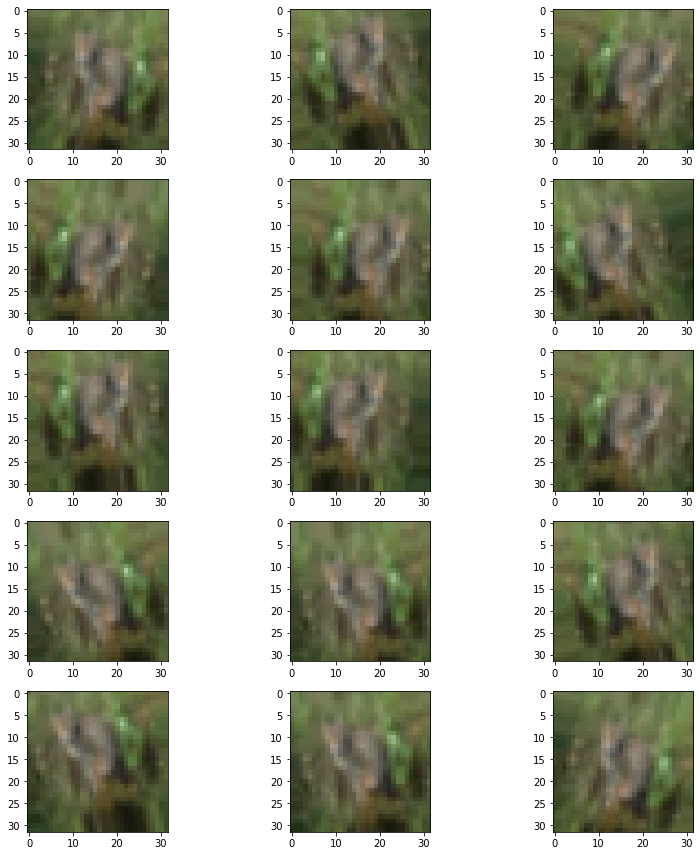

In [ ]:
# checking the transformations of the already created generators
sample = np.random.choice(range(0,4999))

example_generator = train_datagen.flow(
    x_train[sample:sample+1],
    y_train[sample:sample+1],
    batch_size=1
)

plt.figure(figsize=(12, 12))
for i in range(0,15):
    plt.subplot(5, 3, i+1)
    for X,y in example_generator:
        image = X[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

#### 4.9.2. Training the model with the image train generator <a class="anchor" id="train_generator_training_model"></a>

DEFINITION
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 8, 8, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 8, 8, 256)         295168    
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 4, 4, 

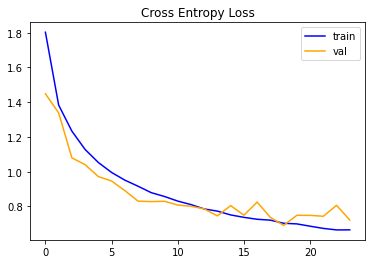

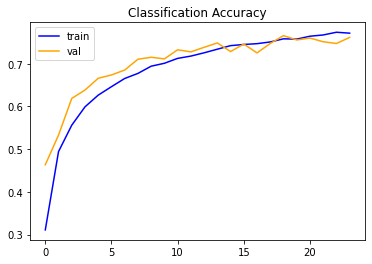

Test Accuracy for the model -> 75.72 %



In [ ]:
# MODEL DEFINITION
print("DEFINITION")

model = ks.Sequential()

# Neural Network Layers

model.add(ks.layers.Conv2D(64, (3, 3), strides = 1, activation = 'relu', padding = 'same', input_shape = INPUT_SHAPE))
model.add(ks.layers.MaxPooling2D((2, 2)))

model.add(ks.layers.Conv2D(128, (3, 3), strides = 1, activation = 'relu', padding = 'same'))
model.add(ks.layers.MaxPooling2D((2, 2)))

model.add(ks.layers.Conv2D(256, (3, 3), strides = 1, activation = 'relu', padding = 'same'))
model.add(ks.layers.MaxPooling2D((2, 2)))

model.add(ks.layers.Conv2D(512, (3, 3), strides = 1, activation = 'relu', padding = 'same'))
model.add(ks.layers.MaxPooling2D((2, 2)))

model.add(ks.layers.Conv2D(512, (3, 3), strides = 1, activation = 'relu', padding = 'same'))
model.add(ks.layers.MaxPooling2D((2, 2)))

model.add(ks.layers.Flatten()) 
model.add(ks.layers.Dense(4096, activation='relu'))
model.add(ks.layers.Dropout(0.25))
model.add(ks.layers.Dense(1024, activation='relu'))
model.add(ks.layers.Dropout(0.25))
model.add(ks.layers.Dense(10, activation='softmax'))

# review model
model.summary()


# COMPILING MODEL
print("\nCompiling model...")
model.compile(optimizer = 'Adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])


# TRAINING
print("\nTRAINING")
# calculating computational time
t = time.perf_counter()
# training model
history = model.fit(
                    train_generator, 
                    validation_data = validation_generator,
                    epochs = EPOCHS, 
                    steps_per_epoch = int(x_train.shape[0] / generator_batch_size),
                    use_multiprocessing = False, 
                    callbacks = [callback_accuracy, callback_loss]
          )
# show total elapsed time
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))
print('\n\nTraining time:', elapsed_time)


# EVALUATION
print("\nEVALUATION")
acc = model_evaluation(model, x_test, y_test_encoded, history, True)

In [ ]:
storing_evaluation_results(model_evaluations, 'CNN using Data Augmentation', acc, elapsed_time)

### 4.10. Concatenating convolutional layers before Pooling (with Data Augmentation and BatchNormalization) <a class="anchor" id="convo_concat_batchNorm_DA"></a>

In this iteration, we will be adding more convolutional layers before performing MaxPooling. Also, we will be making use of BatchNormalization.

Batch normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks. Since there will be a ton of parameters to train, this is an approach

DEFINITION
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_21 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                           

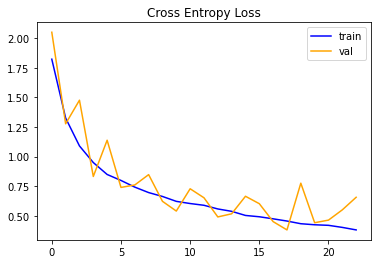

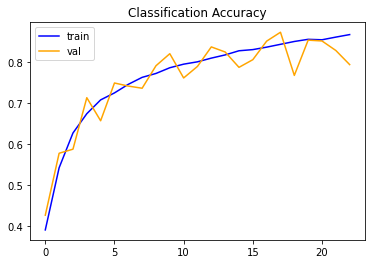

Test Accuracy for the model -> 86.63 %



In [ ]:
# MODEL DEFINITION
print("DEFINITION")

model = ks.Sequential()

# Neural Network Layers

model.add(ks.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.MaxPooling2D((2, 2)))
model.add(ks.layers.Dropout(0.3))

model.add(ks.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.MaxPooling2D((2, 2)))
model.add(ks.layers.Dropout(0.3))

model.add(ks.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.MaxPooling2D((2, 2)))
model.add(ks.layers.Dropout(0.3))

model.add(ks.layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.MaxPooling2D((2, 2)))
model.add(ks.layers.Dropout(0.3))

model.add(ks.layers.Flatten()) 
model.add(ks.layers.Dense(4096, activation='relu'))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Dropout(0.3))
model.add(ks.layers.Dense(1024, activation='relu'))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Dropout(0.3))
model.add(ks.layers.Dense(10, activation='softmax'))

# review model
model.summary()


# COMPILING MODEL
print("\nCompiling model...")
model.compile(optimizer = 'Adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])


# TRAINING
print("\nTRAINING")
# calculating computational time
t = time.perf_counter()
# training model
history = model.fit(
                    train_generator, 
                    validation_data = validation_generator,
                    epochs = EPOCHS, 
                    steps_per_epoch = int(x_train.shape[0] / generator_batch_size),
                    use_multiprocessing = False, 
                    callbacks = [callback_accuracy, callback_loss]
          )
# show total elapsed time
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))
print('\n\nTraining time:', elapsed_time)


# EVALUATION
print("\nEVALUATION")
acc = model_evaluation(model, x_test, y_test_encoded, history, True)

In [ ]:
storing_evaluation_results(model_evaluations, 'Additional convolutional layers + DA', acc, elapsed_time)

### 4.11. Is Data Augmentation a key factor for accuracy? <a class="anchor" id="is_DA_needed"></a>



DEFINITION
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_76 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_70 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_77 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_71 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                          

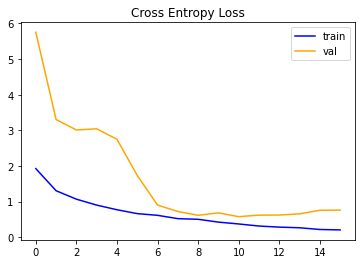

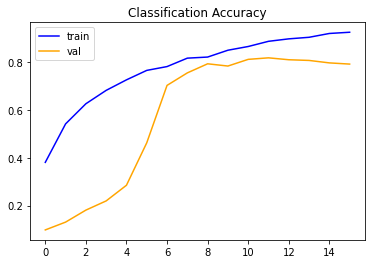

Test Accuracy for the model -> 80.44 %



In [ ]:
# MODEL DEFINITION
print("DEFINITION")

model = ks.Sequential()

# Neural Network Layers

model.add(ks.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.MaxPooling2D((2, 2)))
model.add(ks.layers.Dropout(0.3))

model.add(ks.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.MaxPooling2D((2, 2)))
model.add(ks.layers.Dropout(0.3))

model.add(ks.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.MaxPooling2D((2, 2)))
model.add(ks.layers.Dropout(0.3))

model.add(ks.layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.MaxPooling2D((2, 2)))
model.add(ks.layers.Dropout(0.3))

model.add(ks.layers.Flatten()) 
model.add(ks.layers.Dense(4096, activation='relu'))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Dropout(0.3))
model.add(ks.layers.Dense(1024, activation='relu'))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Dropout(0.3))
model.add(ks.layers.Dense(10, activation='softmax'))

# review model
model.summary()


# COMPILING MODEL
print("\nCompiling model...")
model.compile(optimizer = 'Adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])


# TRAINING
print("\nTRAINING")
# calculating computational time
t = time.perf_counter()
# training model
history = model.fit(
                    x_train, 
                    y_train, 
                    epochs = EPOCHS, 
                    use_multiprocessing = False, 
                    batch_size = 512, 
                    validation_data = (x_val, y_val),
                    callbacks = [callback_accuracy, callback_loss]
          )
# show total elapsed time
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))
print('\n\nTraining time:', elapsed_time)


# EVALUATION
print("\nEVALUATION")
acc = model_evaluation(model, x_test, y_test, history, True)

In [ ]:
storing_evaluation_results(model_evaluations, 'Additional convolutional layers - DA', acc, elapsed_time)

### 4.12. Using an already trained 3rd party model (Transfer Learning)<a class="anchor" id="transfer_learning"></a>

In this section we will be using an already existing convolutional network architecture using the VGG19 model available in Tensorflow.

In [ ]:
# instantiating vgg19
vgg = vgg19.VGG19(include_top = False, weights = 'imagenet', input_shape = INPUT_SHAPE)
vgg.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                              

In [ ]:
# connecting a Flatten layer to the output, so we can plug it into our Dense layer model
output = vgg.layers[-1].output
new_output_layer = ks.layers.Flatten()(output)
vgg_model = Model(vgg.input, new_output_layer)

In [ ]:
vgg_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

In [ ]:
vgg_model.trainable = False # in this section, we will keep the model as it is without retraining any of its blocks

In [ ]:
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer type', 'Name of layer', 'Trainable?'])

,Layer type,Name of layer,Trainable?
0,<keras.engine.input_layer.InputLayer object at...,input_3,False
1,<keras.layers.convolutional.Conv2D object at 0...,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0...,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0...,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0...,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0...,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0...,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0...,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0...,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0...,block3_conv3,False


DEFINITION
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_2 (Functional)        (None, 512)               20024384  
                                                                 
 dense_69 (Dense)            (None, 4096)              2101248   
                                                                 
 dropout_72 (Dropout)        (None, 4096)              0         
                                                                 
 dense_70 (Dense)            (None, 1024)              4195328   
                                                                 
 dropout_73 (Dropout)        (None, 1024)              0         
                                                                 
 dense_71 (Dense)            (None, 10)                10250     
                                                                 
Total params: 26,331,210
Trainable params:

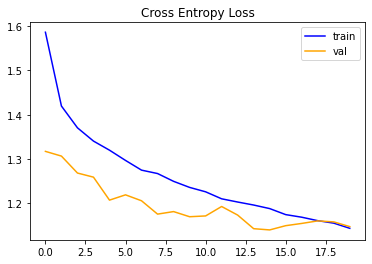

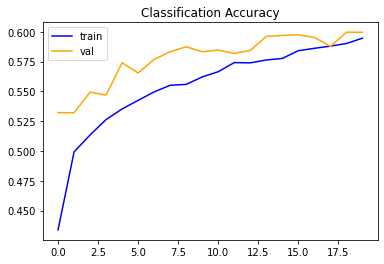

Test Accuracy for the model -> 59.1 %



In [ ]:
# MODEL DEFINITION
print("DEFINITION")

model = ks.Sequential()

# Neural Network Layers
model.add(vgg_model)
model.add(ks.layers.Dense(4096, activation='relu', input_shape = (input_shape,)))
model.add(ks.layers.Dropout(0.25))
model.add(ks.layers.Dense(1024, activation='relu'))
model.add(ks.layers.Dropout(0.25))
model.add(ks.layers.Dense(10, activation='softmax'))

# review model
model.summary()


# COMPILING MODEL
print("\nCompiling model...")
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# TRAINING
print("\nTRAINING")
# calculating computational time
t = time.perf_counter()
# training model
history = model.fit(
                    train_generator, 
                    validation_data = validation_generator,
                    epochs = EPOCHS, 
                    steps_per_epoch = int(x_train.shape[0] / generator_batch_size),
                    use_multiprocessing = False, 
                    callbacks = [callback_accuracy, callback_loss]
)
# show total elapsed time
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))
print('\n\nTraining time:', elapsed_time)


# EVALUATION
print("\nEVALUATION")
acc = model_evaluation(model, x_test, y_test_encoded, history, True)

It seems that with VGG19 as it is, this won't help our model to do better. However, there's the option to retrain everything back to our own dataset, which is what will be done in the next section.

In [ ]:
storing_evaluation_results(model_evaluations, 'Transfer Learning - using VGG as it is', acc, elapsed_time)

### 4.13. Extending Transfer Learning to retrain already created models<a class="anchor" id="transfer_learning_retraining"></a>

As seen before, the model as it is doesn't work, can we retrain the whole architecture to achieve a better result?

In [ ]:
# making the whole model trainable
vgg_model.trainable = True
vgg_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

In [ ]:
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer type', 'Name of layer', 'Trainable?'])

,Layer type,Name of layer,Trainable?
0,<keras.engine.input_layer.InputLayer object at...,input_3,True
1,<keras.layers.convolutional.Conv2D object at 0...,block1_conv1,True
2,<keras.layers.convolutional.Conv2D object at 0...,block1_conv2,True
3,<keras.layers.pooling.MaxPooling2D object at 0...,block1_pool,True
4,<keras.layers.convolutional.Conv2D object at 0...,block2_conv1,True
5,<keras.layers.convolutional.Conv2D object at 0...,block2_conv2,True
6,<keras.layers.pooling.MaxPooling2D object at 0...,block2_pool,True
7,<keras.layers.convolutional.Conv2D object at 0...,block3_conv1,True
8,<keras.layers.convolutional.Conv2D object at 0...,block3_conv2,True
9,<keras.layers.convolutional.Conv2D object at 0...,block3_conv3,True


DEFINITION
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_2 (Functional)        (None, 512)               20024384  
                                                                 
 dense_72 (Dense)            (None, 4096)              2101248   
                                                                 
 dropout_74 (Dropout)        (None, 4096)              0         
                                                                 
 dense_73 (Dense)            (None, 1024)              4195328   
                                                                 
 dropout_75 (Dropout)        (None, 1024)              0         
                                                                 
 dense_74 (Dense)            (None, 10)                10250     
                                                                 
Total params: 26,331,210
Trainable params:

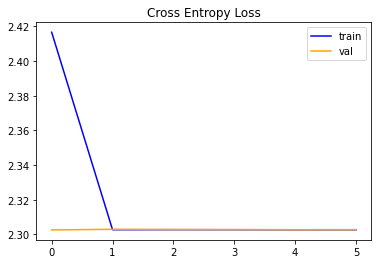

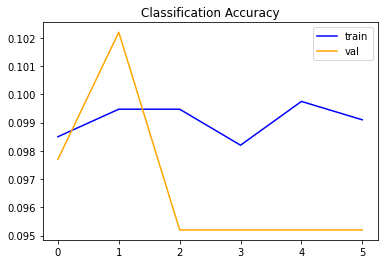

Test Accuracy for the model -> 10.0 %



In [ ]:
# MODEL DEFINITION
print("DEFINITION")

model = ks.Sequential()

# Neural Network Layers
model.add(vgg_model)
model.add(ks.layers.Dense(4096, activation='relu', input_shape = (input_shape,)))
model.add(ks.layers.Dropout(0.25))
model.add(ks.layers.Dense(1024, activation='relu'))
model.add(ks.layers.Dropout(0.25))
model.add(ks.layers.Dense(10, activation='softmax'))

# review model
model.summary()


# COMPILING MODEL
print("\nCompiling model...")
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# TRAINING
print("\nTRAINING")
# calculating computational time
t = time.perf_counter()
# training model
history = model.fit(
                    train_generator, 
                    validation_data = validation_generator,
                    epochs = EPOCHS, 
                    steps_per_epoch = int(x_train.shape[0] / generator_batch_size),
                    use_multiprocessing = False, 
                    callbacks = [callback_accuracy, callback_loss]
)
# show total elapsed time
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))
print('\n\nTraining time:', elapsed_time)


# EVALUATION
print("\nEVALUATION")
acc = model_evaluation(model, x_test, y_test_encoded, history, True)

After retraining the whole model, we see that the VGG16 architecture may not be good for the current dataset, as the accuracy is the same as if we told the model to toss a 10-face dice to predict the class.

As a side note, re-training only a part of the model was also tested, but the results were totally the same.

In [ ]:
storing_evaluation_results(model_evaluations, 'Transfer Learning - re-training whole VGG', acc, elapsed_time)

## 5. Models comparison <a class="anchor" id="comparison"></a>

In [ ]:
# generating a dataframe with all models and its results
df = pd.DataFrame(model_evaluations)

# data transformations
df['training_time'] = df['training_time'].apply(lambda x: round(x.total_seconds(), 2))
df['accuracy'] = round(df['accuracy'] * 100, 2)

In [ ]:
df

,model_name,training_time,accuracy
0,Single Dense Layer,29.88,45.36
1,Several Dense Layers,23.87,49.68
2,Increasing Batch Size,11.22,49.16
3,Adding Dropout Layers,14.11,43.37
4,Simple Convolutional Neural Network,14.56,62.12
5,Complex Convolutional Neural Network,20.28,70.48
6,VGG16-like CNN,38.57,69.83
7,Fine tuning Adam Optimizer parameters,39.66,69.94
8,CNN using Data Augmentation,588.04,75.72
9,Additional convolutional layers + DA,594.27,86.63


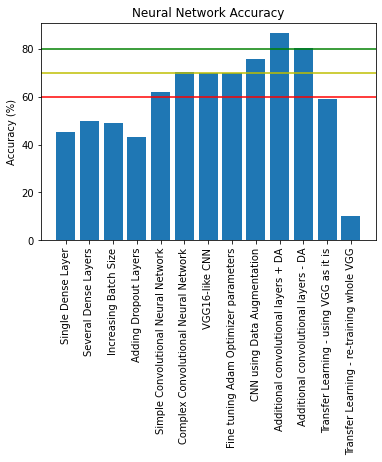

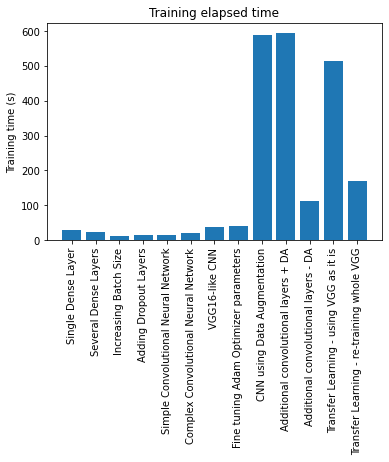

In [ ]:
plt.title('Neural Network Accuracy')
plt.bar(x = df['model_name'], height = df['accuracy'])
plt.axhline(y=ACC_TARGET , color='g', linestyle='-')
plt.axhline(y=ACC_TARGET - 10, color='y', linestyle='-')
plt.axhline(y=ACC_TARGET - 20, color='r', linestyle='-')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation = 90)
plt.show()

plt.title('Training elapsed time')
plt.bar(x = df['model_name'], height = df['training_time'])
plt.ylabel('Training time (s)')
plt.xticks(rotation = 90)
plt.show()

The analysis of the performance of each architecture will be done based in 2 factors: The accuracy of the architecture and the time it took to perform its training (and image pre-processing).

The following are conclusions we can derive from our testst:
- `Single Dense Layer` gave us the bottom in terms of accuracy and also a pretty low training time, but due to its super low accuracy this is not a model we would be using in production.
- When trying to improve to adding `Several Dense Layers` the training time, of course, increased. However, even though the accuracy increased an additional percentage (aproximately an average of 10% after several trainings) this is not good enough to reach a comfortable 80% accuracy.
- Since we just played around with the architecture, we wanted to explore if the `batch_size` was a good parameter to fine tune to improve both accuracy and training time. In `Increasing Batch Size` this parameter was increased up to `512`. The results in terms of accuracy were similar (with a slight decrease from having several dense layers), but the training time was even lower than with the single dense layer (being the lowest among all our architectures).
- After that, we were looking to explore what would happen when `Adding Dropout Layers`. However, the results were similar to the single dense layer architecture, but having a better structure than this one. So, that didn't help that much.
- Once we explored all the simple architectures and parameters, we decided to go for Convolutional Neuronal Networks, in order to provide the algorithm with the vision to interpret images, which is the one that the convolutional layer blocks provide to the neural network. With the `Simple Convolutional Neural Network`, which only had one convolutional layer, the results in accuracy dramatically increased, breaking the barrier of the 60% accuracy. The good thing is that the training time didn't increase that much, which is also good. 
- But we were still not happy with the result in terms of accuracy. So, we wanted to improve the structure of the CNN by adding more convolutional layers in `Complex Convolutional Neural Network`. The increase in accuracy was low, but about to reach the 70%. The training time was affected but not that much.
- After that, we decided to move to a more `VGG-16` like network structure with more bigger convolutional layers, and also increasing the amount of Dense Layers in `VGG-16 like CNN`. With it the 70% accuracy limit was reached, but the training time grew up to more than the double.
- Before moving to Data Augmentation, we wanted to see if fine tuning the parameters in the `Adam` optimizer, like the learning rate or the momentum, could affect. The results were pretty similar to the `VGG-16 like CNN` in terms of accuracy, but the training time was reduced.
- Having tried all possible options, we decided to move to try Data Augmentation to see if the accuracy could be improved by increasing the data set of images using automatically generated ones that were transformations from the original dataset in `CNN Using Data Augmentation`. From the several tests that were made, with the same complex convolutional network than in `Complex Convolutional Neural Network`, the increase in accuracy was very low but the training time was huge. So the results were better when no Data Augmentation was being used.
- But, it is a known fact that Data Augmentation should help in accuracy increase, so it was decided to test an even more complex convolutional neural network with more layers, before pooling and increasing its complexity in `Additional Convolutional Layers + DA`. For the first time, the 80% barrier in terms of accuracy was reached, providing the highest accuracy of all tested models. However, the Data Augmentation pre-processing made it also the slowest to train model.
- Since we weren't sure if that increase was due to the fact that Data Augmentation was included, or if it was because of the more complex convolutional network, we decided to try the same model, but without using Data Augmentation in `Additional convolutional layers - DA`. The results were surprising, because the results showed that the huge increase in accuracy came because of the neural network structure and not by the Data Augmentation part (there's around +6% increase in accuracy when using Data Augmentation). Plus, the training time is hugely reduced. We believe that this may be due to the fact that we have been a little bit aggressive with the data augmentation, taking into account that the images are just 32x32 pixels and its quality is pretty bad. Nonetheless, this is something to be tried in the future.
- Having tried all that with our own knowledge, we thought about seeking the help of other trained models available and make use of Transfer Learning to help our purposes. In `Transfer Learning - using VGG as it is`, we loaded VGG19 and connected it with our fully connected neural network. The results in accuracy were very low (below 60%, even worse than with a basic convolutional network) and the training time was also pretty big, most likely due to the Data Augmentation.
- Since the previous scenario failed, then the next logical step was to make use of the already existing architecture and re-train it completely within the context in our dataset. In `Transfer Learning - re-training whole VGG`, we re-trained the whole network, but we got even worse results (like throwing a 10-face dice). Maybe the dataset, since it's a set of very small images 32x32, with the current architecture's poolings and kernels used it's giving bad results. As a side note, re-training a part of the network was also tested, but with the same results.